In [25]:
import torch
#torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
#import warnings
#warnings.filterwarnings('ignore')

In [26]:
device = 'cuda' # this will be used to transfer images to GPU device : image = image.to(device)
batch_size = 128
noise_dim = 64

# optimizers patameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 25

In [27]:
from torchvision import datasets, transforms as T

In [28]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)  # changing the images to torch tensors
])

In [29]:
trainset = datasets.MNIST('MNIST', download = True, train = True, transform = train_augs)

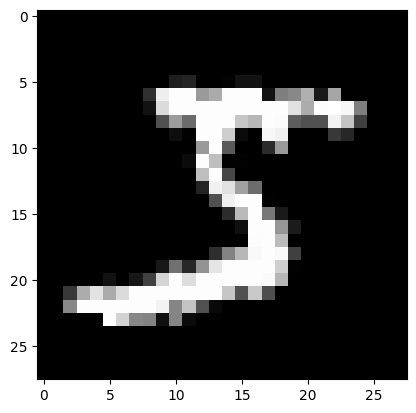

In [30]:
image, label = trainset[0]
plt.imshow(image.squeeze(), cmap = 'gray')

In [31]:
print("total images present in trainset are: ", len(trainset))

total images present in trainset are:  60000


In [32]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [33]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle = True)
print("total number of batches in tarinloader: ", len(trainloader))

total number of batches in tarinloader:  469


In [34]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [35]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

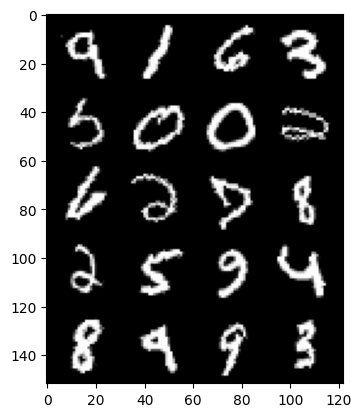

In [36]:
show_tensor_images(images, num_images = 20)

In [37]:
from torch import nn
from torchsummary import summary

In [38]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [39]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [40]:
import torch
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = Discriminator()
D.to(device)
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [41]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [42]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)

        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):

        #(bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4

In [43]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [44]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [45]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In [46]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss
def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [47]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas=(beta_1, beta_2))

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6841085110900245 | G_loss: 0.7133359992936221


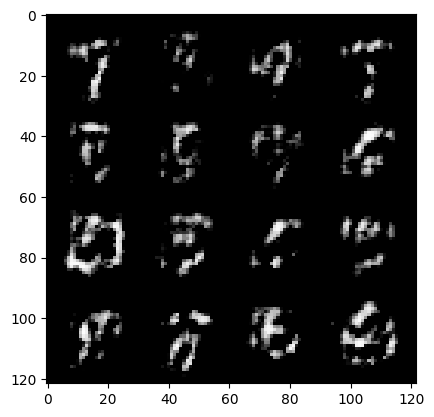

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6672320810716543 | G_loss: 0.7212737503844792


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.6216223886780647 | G_loss: 0.7766852361052784


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.5877365201775199 | G_loss: 0.8282176085880825


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.5661554757211762 | G_loss: 0.8728048444302605


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.5644206778327031 | G_loss: 0.8932001196753496


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.5692698438284494 | G_loss: 0.8980188174034233


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.5796128608016317 | G_loss: 0.8966781147507462


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.5897801118110543 | G_loss: 0.8927077586208579


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.5976806687139499 | G_loss: 0.8844459932496045


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6026128268699402 | G_loss: 0.8811086950017445


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6065999274569025 | G_loss: 0.8825527810847072


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.6115395401332424 | G_loss: 0.8759772420437859


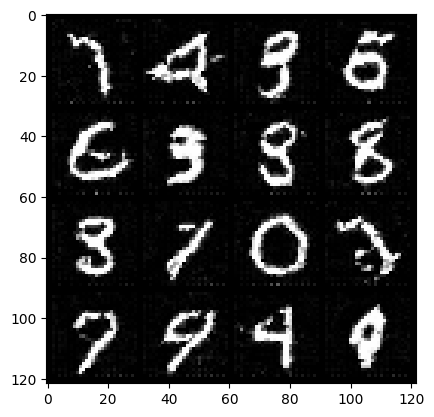

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6115332372915516 | G_loss: 0.8747648220580778


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.61466421158329 | G_loss: 0.8720526663479267


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.6167140289156168 | G_loss: 0.8744472205511796


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.6191264479907591 | G_loss: 0.8712775376814006


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6200910091145969 | G_loss: 0.8743063358864042


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6192233226955064 | G_loss: 0.872381623746998


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.6189697486505326 | G_loss: 0.8744329732618352


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 21 | D_loss: 0.6202476691843858 | G_loss: 0.8719048876243868


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 22 | D_loss: 0.6189570208348191 | G_loss: 0.8799002971222152


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 23 | D_loss: 0.6195340188327374 | G_loss: 0.8831072763593466


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 24 | D_loss: 0.6218007928781164 | G_loss: 0.877806170154482


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 25 | D_loss: 0.6195515760226544 | G_loss: 0.8814050991143754


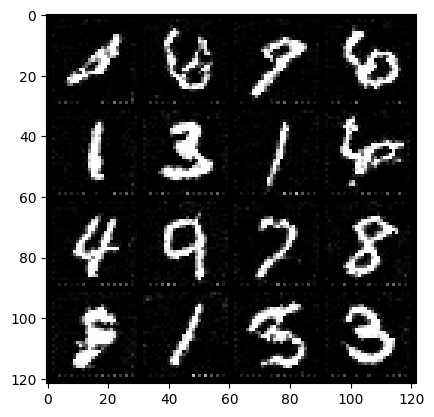

In [48]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device = device)

        # find loss and update weights for D

        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        # find loss and update weights for G

        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device = device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

    if (i==0 or i==round(epochs/2) or i==epochs-1):
        show_tensor_images(fake_img)

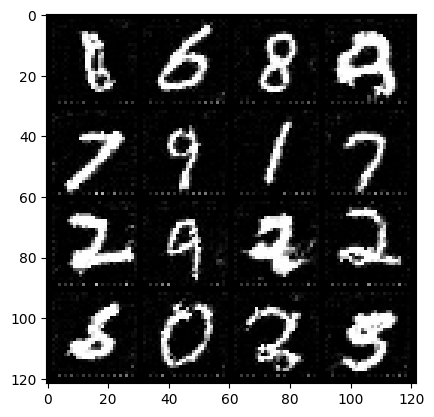

In [49]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

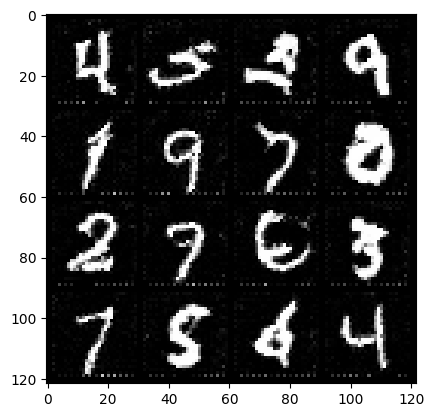

In [50]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)